In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

import warnings

In [10]:
sns.set()

warnings.filterwarnings('ignore')

%matplotlib inline

DATAPATH = 'stock_prices_sample.csv'

In [6]:
def mean_abs_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [12]:
# parse_dates is used to set the column type as DATETIME

data = pd.read_csv(DATAPATH, index_col=['DATE'], parse_dates=['DATE'])
data.head(5)

,TICKER,FIGI,TYPE,FREQUENCY,OPEN,HIGH,LOW,CLOSE,VOLUME,ADJ_OPEN,ADJ_HIGH,ADJ_LOW,ADJ_CLOSE,ADJ_VOLUME,ADJ_FACTOR,EX_DIVIDEND,SPLIT_RATIO
DATE,,,,,,,,,,,,,,,,,
2013-01-04,GEF,BBG000BLFQH8,EOD,daily,46.31,47.6198,46.23,47.37,248000.0,38.517220,39.606614,38.450681,39.398849,248000.0,NaN,0.0,1.0
2013-01-03,GEF,BBG000BLFQH8,EOD,daily,46.43,46.5200,46.14,46.48,131300.0,38.617027,38.691882,38.375826,38.658613,131300.0,NaN,0.0,1.0
2013-01-02,GEF,BBG000BLFQH8,EOD,daily,45.38,46.5400,45.16,46.41,184900.0,37.743715,38.708516,37.560735,38.600392,184900.0,NaN,0.0,1.0
2018-06-05,GF,BBG000C3C6S2,Intraday,daily,18.86,18.9100,18.87,18.87,10000.0,18.860000,18.910000,18.870000,18.870000,10000.0,NaN,0.0,1.0
2018-06-04,GF,BBG000C3C6S2,EOD,daily,18.86,18.8900,18.79,18.81,39095.0,18.860000,18.890000,18.790000,18.810000,39095.0,NaN,0.0,1.0


CLEAN THE DATA

In [16]:
# removes "GEF" entries from column TICKER  as we are interested only in GF
data = data[data.TICKER != 'GEF']
# removes "Intraday" entries from column TYPE as we are interested only in EOD
data = data[data.TYPE != 'Intraday']
# removes unwanted columns
drop_cols = ['SPLIT_RATIO', 'EX_DIVIDEND', 'ADJ_FACTOR', 'ADJ_VOLUME', 'ADJ_CLOSE', 'ADJ_LOW', 'ADJ_HIGH', 'ADJ_OPEN', 'VOLUME', 'FREQUENCY', 'TYPE', 'FIGI']
data.drop(drop_cols, axis=1, inplace=True)

data.head()

,TICKER,OPEN,HIGH,LOW,CLOSE
DATE,,,,,
2018-06-04,GF,18.86,18.890,18.7900,18.8100
2018-06-01,GF,18.58,18.760,18.5800,18.7400
2018-05-31,GF,18.52,18.520,18.3012,18.4900
2018-05-30,GF,18.47,18.678,18.4700,18.6500
2018-05-29,GF,18.51,18.510,18.1500,18.2562


EXPLORATORY DATA ANALYSIS

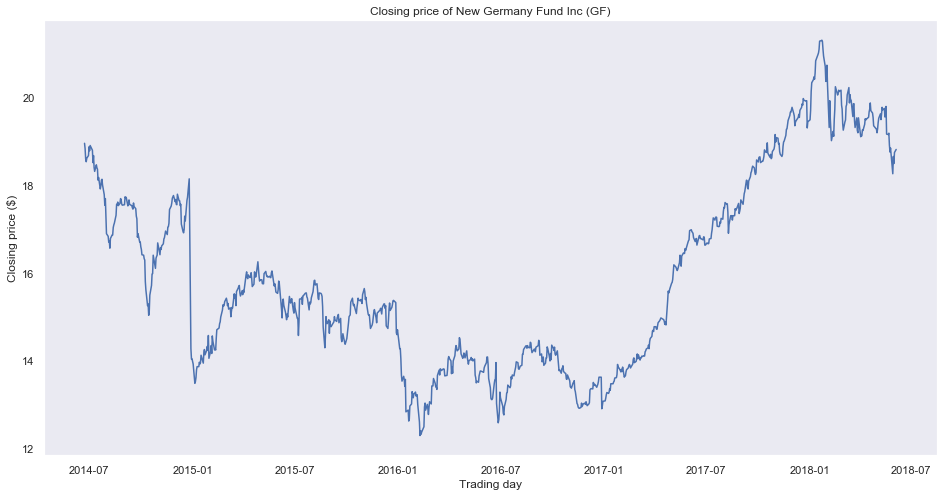

In [28]:
# sets the canvas
plt.figure(figsize=(16,8))
# plots the data
plt.plot(data.CLOSE)
# adds title
plt.title('Closing price of New Germany Fund Inc (GF)')
# adds labels
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
# removes grid lines
plt.grid(False)
# shows the graph
plt.show()

# Not stationary. Seasonality unsure

MOVING AVERAGE

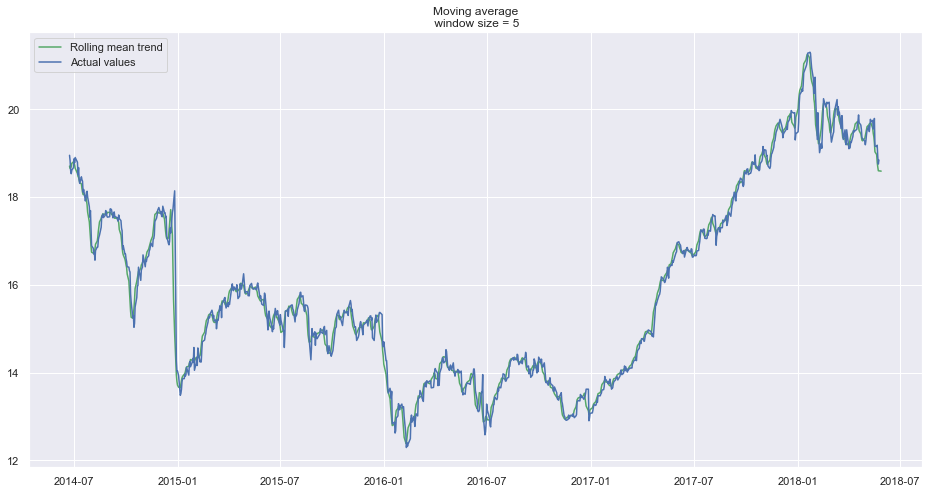

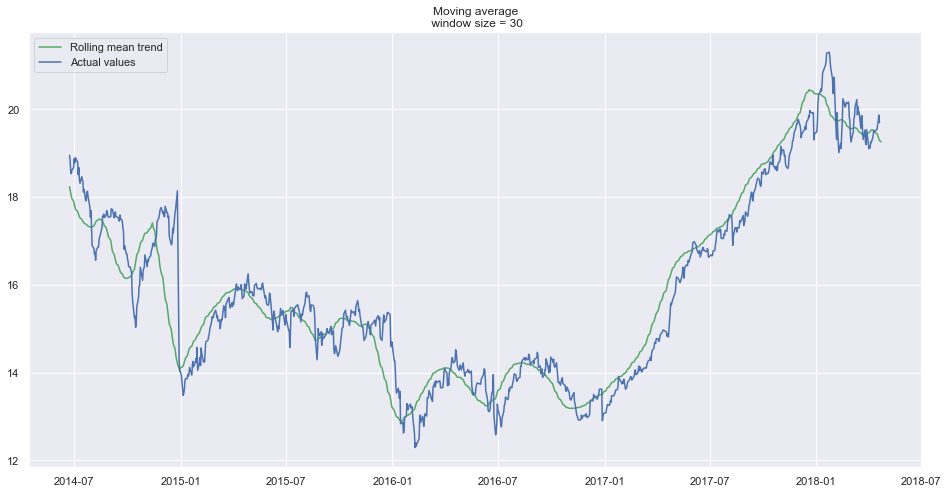

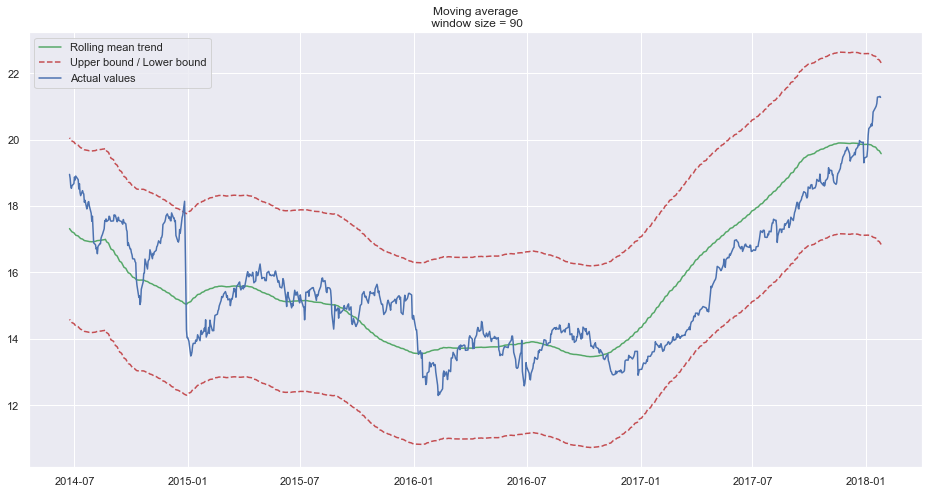

In [45]:
def plot_moving_average(series, window, plot_intervals=False, scale=2):

    # calculating the moving average
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(16,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, color='g', label='Rolling mean trend')

    # Plot confidence intervals for smoothing
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')

    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

#Smooth by the previous 5 days (by week)
plot_moving_average(data.CLOSE, 5)

#Smooth by the previous month (30 days)
plot_moving_average(data.CLOSE, 30)

#Smooth by previous quarter (90 days)
plot_moving_average(data.CLOSE, 90, plot_intervals=True)

EXPONENTIAL SMOOTHING

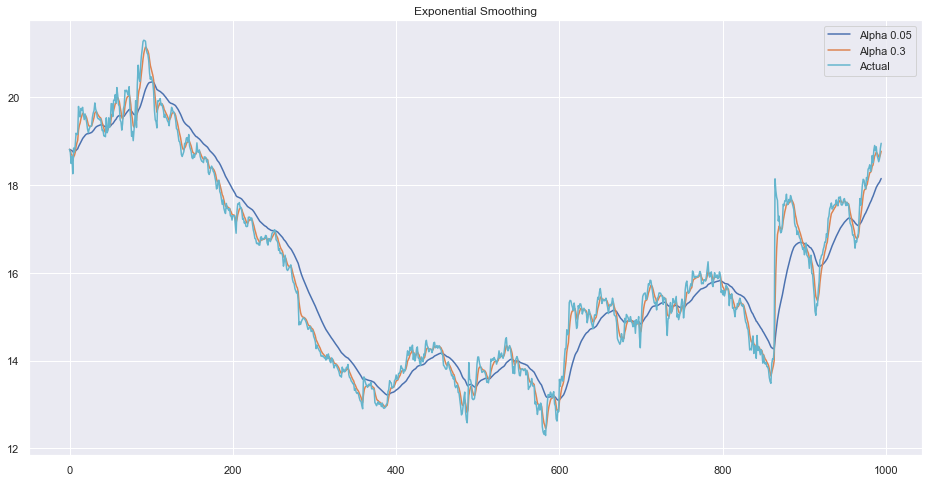

In [46]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])

    return result


def plot_exponential_smoothing(series, alphas):

    plt.figure(figsize=(16,8))
    
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))

    plt.plot(series.values, "c", label="Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

plot_exponential_smoothing(data.CLOSE, [0.05, 0.3])